In [8]:
import cartopy.crs as ccrs
from glob import glob
from shapely import box
import matplotlib.pyplot as plt
import json
from shapely import wkt
import os
from tqdm import tqdm
import pandas as pd
import xarray as xr
import rioxarray as rio
import src.utils as utils
import numpy as np
# import warnings
# from dask.distributed import LocalCluster, Client

In [ ]:
# cluster = LocalCluster()
# client = cluster.get_client()

In [9]:
dirs = glob('data/arcticDEM/id*')

In [10]:
## plotting helpers
def get_line(d):
    '''
    grab centreline from directory
    '''
    with open(f'{d}/download_notes.txt', 'r') as notes:
        notes = json.load(notes)
        return wkt.loads(notes['centreline'])

def get_ds(d):
    '''
    grab dem trend from directory
    '''
    _f = glob(f'{d}/coregistered/robust_spatial*.zarr')
    assert len(_f) == 1, 'not enough / too many .zarr dems'
    return xr.open_dataarray(_f[0], engine='zarr')

In [180]:
def coords_of_point(p):
    '''
    print lat N/S lon E/W for shapely point
    '''
    ycond = [p.y>=0, p.y<0]
    ychoice = [f'{p.y:.2f} N', f'{-1*p.y:.2f} S']
    ytext = np.select(ycond, ychoice)
    
    xcond = [p.x>=0, p.x<0]
    xchoice = [f'{p.x:.2f} E', f'{-1*p.x:.2f} W']
    xtext = np.select(xcond, xchoice)
    
    return f'{ytext} {xtext}'

def spatial_plot(d, ax):
    '''
    plot dh/dt trend from directory d
    onto axes ax
    '''
    line = get_line(d)
    ds = get_ds(d)

    ds.sel(result='slope').plot(
        cmap='RdBu',
        robust=True,
        cbar_kwargs={'label':'dh/dt (m/yr)',
                    # 'orientation':'horizontal',
                    'shrink':0.7},
        ax=ax)
    
    ax.plot(*line.coords.xy, c='k')

    p = box(*ds.rio.bounds()).centroid
    p = utils.shapely_reprojector(p, 3413, 4326)
    title = coords_of_point(p)
    ax.set_title(title)
    # ADD SOME MAGIC TO ALWAYS GENERATE 2-4 GRIDLINES ALONG EACH AXIS
    # gl = ax.gridlines(draw_labels={'left':'y', 'bottom':'x'},
    #                   dms=False, x_inline=False, y_inline=False, rotate_labels=False,
    #                   # ylocs=[63.7, 63.75, 63.85],
    #                   # xlocs=[-50, -49.8, -49.6],
    #                   linewidth=0.5, color='lightgrey'
    #                   )
    

In [250]:
def sample_along_line(d):
    '''
    sample dhdt xarray along centreline
    '''
    ds = get_ds(d)
    line = get_line(d)
    points = [line.interpolate(x/100, normalized=True) for x in range(0,100)]
    distance = [line.project(p)/1000 for p in points]
    x = [p.x for p in points] 
    y = [p.y for p in points]
    df = pd.DataFrame({'distance (km)': distance,
                       'x': x,
                       'y': y})
    idx = df.set_index('distance (km)').to_xarray()
    return ds.interp(x=idx['x'],
                     y=idx['y'])

def plot_profile(d, ax):
    '''
    plot dhdt profile
    '''
    profile = sample_along_line(d)
    profile.sel(result='slope').plot(c='k',
                                     ax=ax)
    high = profile.sel(result='slope').max()
    low = profile.sel(result='slope').min()
    span = high - low
    ax.fill_between(profile['distance (km)'],
                    y1 = profile.sel(result='low_slope'),
                    y2 = profile.sel(result='high_slope'),
                    color='lightgrey',
                    alpha=0.8,
                    label="95% CI")
    ax.set_ylim(low - (high-low),
                high + (high-low))
    ax.set_ylabel('dh/dt (m/yr)')
    ax.legend(loc='upper left')
    ax.axhline(0, c='k', lw=0.5, zorder=0)
    ax.set_title(None)

In [206]:
def get_meta_df(d):
    _f = glob(f'{d}/coregistered/stacked*.csv')
    assert len(_f) == 1, 'not enough / too many .csv files'
    df = pd.read_csv(_f[0], parse_dates=[8,11])
    return df

def plot_stat(d, stat, ax):
    df = get_meta_df(d)
    after = f'after_{stat}'
    before = f'before_{stat}'
    for row in df.iterrows():
        # print(row[0])
        ax.annotate("",
                    xy=(row[1]['to_register_date'], row[1][after]),
                    xytext=(row[1]['to_register_date'], row[1][before]),
                    arrowprops=dict(arrowstyle='->'))
    
    minx, maxx = df['to_register_date'].agg(['min','max'])
    delta = pd.Timedelta('90d')
    ax.set_xlim(minx-delta, maxx+delta)
    ax.set_ylim(*df[[after, before]].melt()['value'].agg(['min','max']))
    
    ax.axhline(0, c='lightgrey', lw=0.5)
    ax.axvline(df.reference_date.unique()[0], ls=':', c='k')
    ax.set_ylabel(f'{stat} (m)')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='center')

def plot_coreg(d, ax):
    df = get_meta_df(d)
    
    plot_df = df[['after_median','before_median','after_nmad','before_nmad']].melt()
    plot_df['when'] = plot_df['variable'].str.split('_').apply(lambda x: x[0])
    plot_df['variable'] = plot_df['variable'].str.split('_').apply(lambda x: x[1])
    sns.violinplot(data=plot_df,
                   x='variable',
                   y='value',
                   hue='when',
                   palette=sns.palettes.color_palette('colorblind')[-2:],
                   hue_order=['before','after'],
                   ax=ax)
    ax.set_ylabel('metres')
    ax.set_xlabel(None)
    ax.axhline(0, c='lightgrey', lw=0.5, zorder=0)
    sns.move_legend(ax, loc='best', title=None)
    


In [147]:
def label_axes(fig):
    import string
    axs = fig.axes
    axs = [ax for ax in axs if ax._label != '<colorbar>']
    alphabet = list(map(chr, range(65, 91)))
    for ax, l in zip(axs, alphabet):
        ax.annotate(l, xy=(-0.1, 1.05),
                    xycoords='axes fraction')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.81it/s]


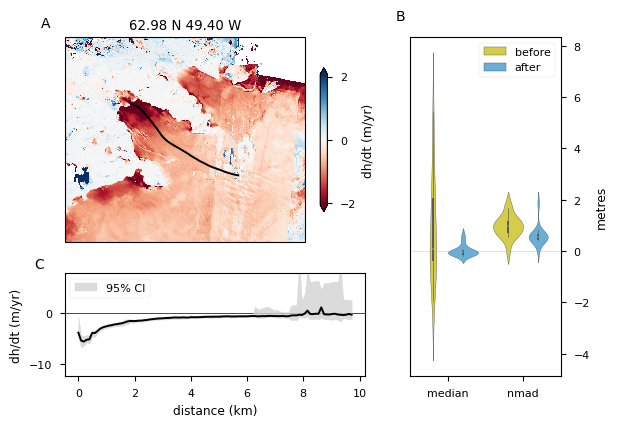

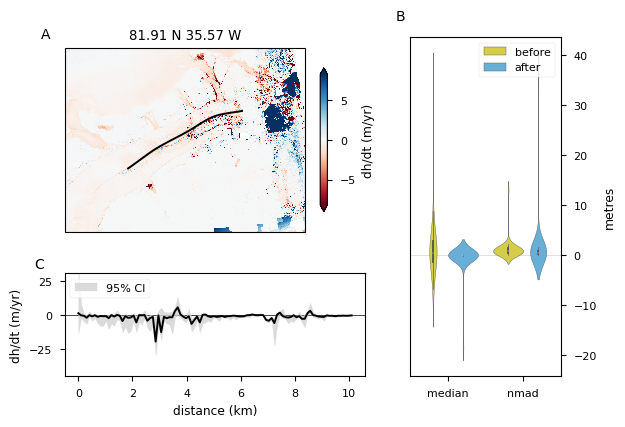

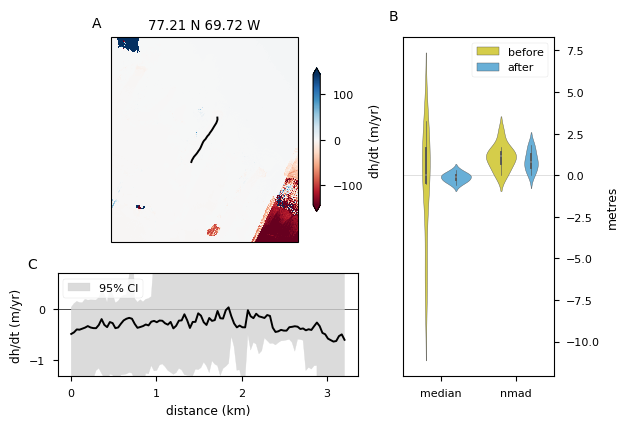

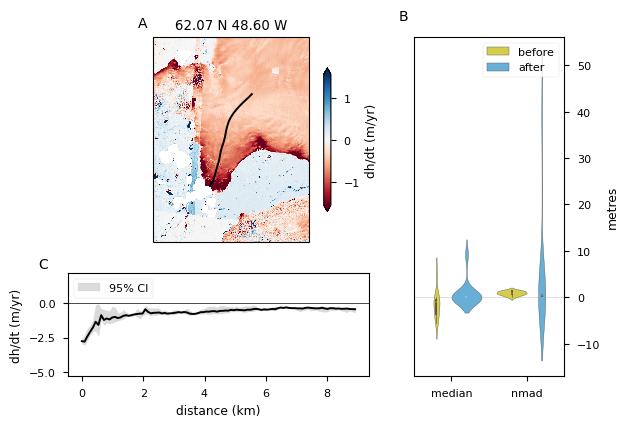

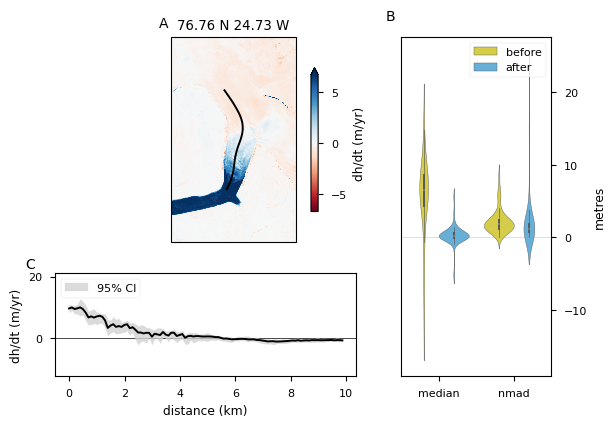

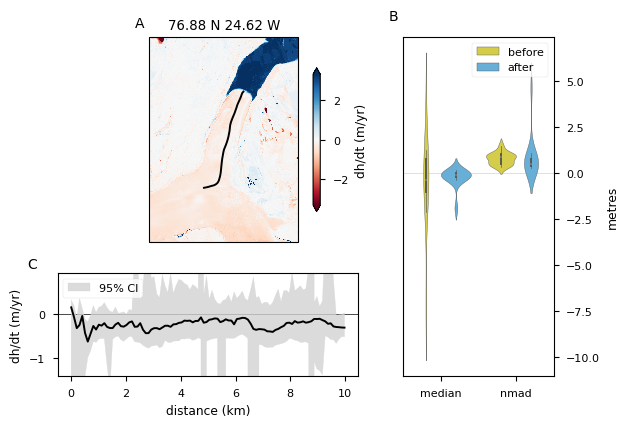

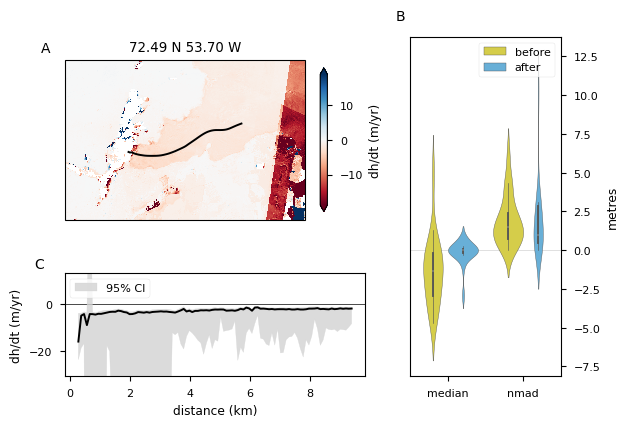

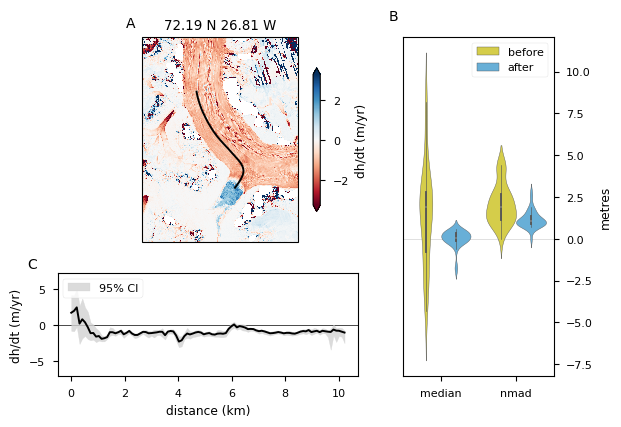

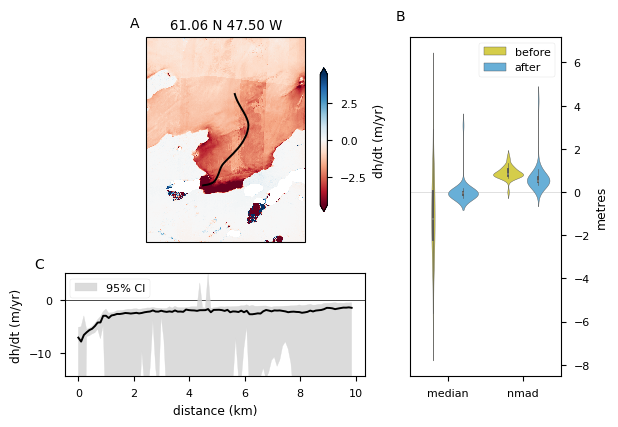

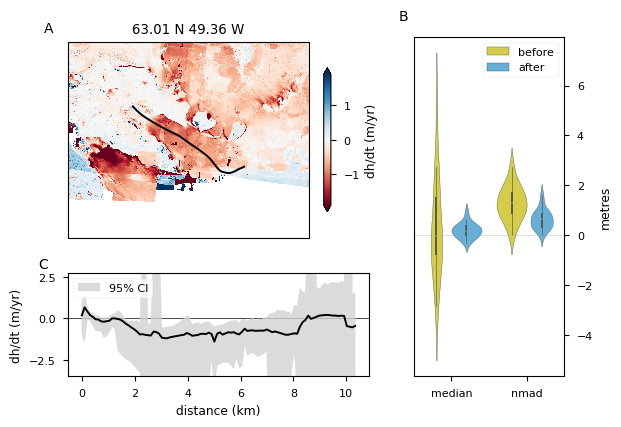

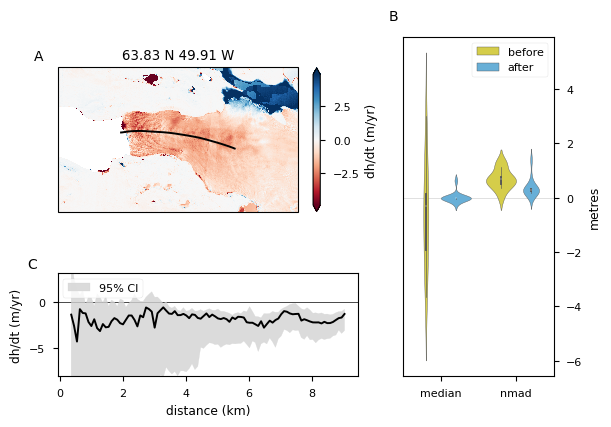

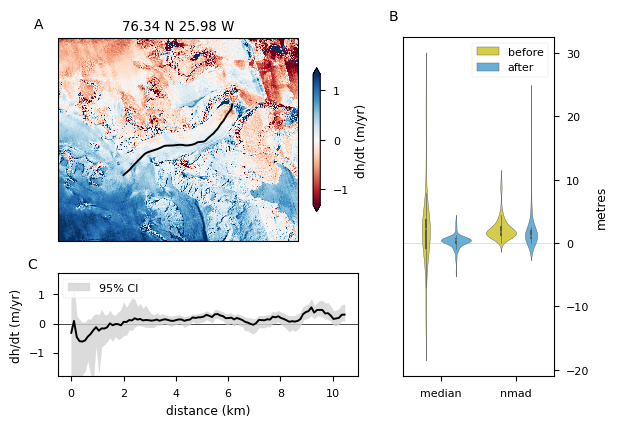

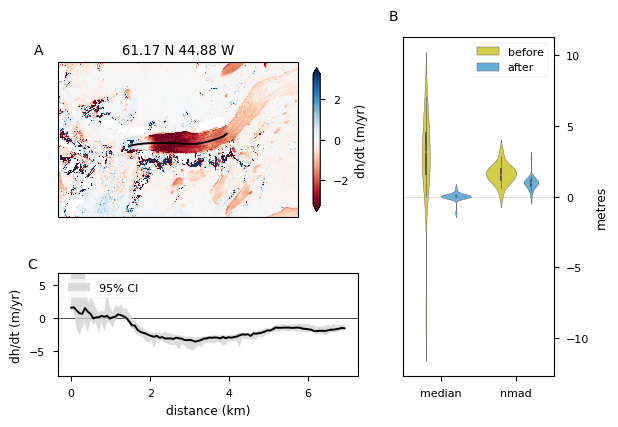

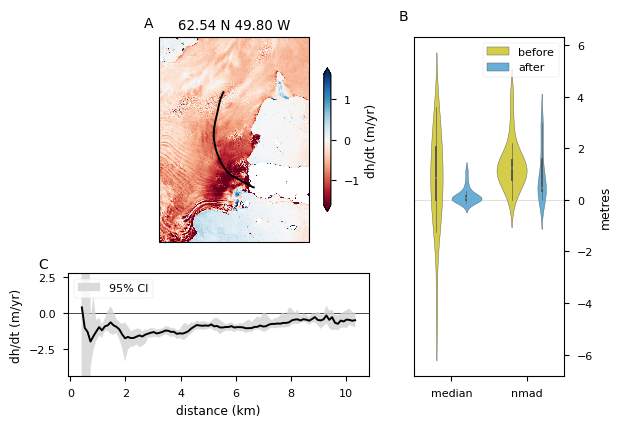

In [252]:
prj = ccrs.Stereographic(central_latitude=90,
                         central_longitude=-45,
                         true_scale_latitude=70)
for d in tqdm(dirs):
    with plt.style.context('seaborn-v0_8-paper'):
        fig, axs = plt.subplot_mosaic(
            [['map', 'coreg'],
             ['profile', 'coreg']],
            height_ratios=[1, 0.5],
            width_ratios=[2, 1],
            per_subplot_kw={'map':{'projection':prj}}
            )
    
        spatial_plot(d, ax=axs['map'])
        plot_profile(d, ax=axs['profile'])
        plot_coreg(d, ax=axs['coreg'])
        axs['coreg'].yaxis.tick_right()
        axs['coreg'].yaxis.set_label_position('right')
        label_axes(fig)
        idx = os.path.basename(d)
        fig.savefig(f'results/elevation_change/{idx}_dhdt.png')